In [1]:
import pickle
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
os.chdir(os.path.expanduser('~/wcEcoli/'))
# noinspection PyUnresolvedReferences
from wholecell.io.tablereader import TableReader
import io
import numpy as np
from wholecell.io import tsv
from wholecell.utils.filepath import ROOT_PATH
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import glob
import plotly.express as px

In [2]:
# function to match gene symbols to monomer ids
def get_gene_symbols_for_monomer_ids():
	"""
	Extracts the gene symbols for each monomer id in the model.
	Returns: a dictionary mapping monomer ids to gene symbols.
	Code adapted from convert_to_flat.py.
	"""
	RNAS_FILE = os.path.join(ROOT_PATH, 'reconstruction', 'ecoli',
								 'flat', 'rnas.tsv')
	with (io.open(RNAS_FILE, 'rb') as f):
		reader = tsv.reader(f, delimiter='\t')
		headers = next(reader)
		while headers[0].startswith('#'):
			headers = next(reader)

		# extract relevant information
		gene_symbol_index = headers.index('common_name')
		protein_id_index = headers.index('monomer_ids')
		monomer_ids_to_gene_symbols = {}
		for line in reader:
			gene_symbol = line[gene_symbol_index]
			protein_id = list(
				line[protein_id_index][2:-2].split('", "'))[0]
			monomer_ids_to_gene_symbols[protein_id] = gene_symbol

	return monomer_ids_to_gene_symbols

def get_common_name(protein_id):
    """
    Get the common name of a protein given its monomer id.
    Args:
        protein_id: the name of the monomer

    Returns:
        common_name: The common name of the protein.

    """
    if '[' in protein_id:
        protein_id = protein_id[:-3]  # subtract the compartment
        
    if protein_id == 'NG-GFP-MONOMER':
        print('NEW GENE PRESENT')
    else:
        common_name = get_gene_symbols_for_monomer_ids()[protein_id]
    return common_name

In [3]:
current_sequence = "CLClim3NE3" # y axis 
CLNE_sequence = "CLNE3"

In [4]:
# read in the CLNE1 half life data: 
CLNE1_HLs = f"out/{CLNE_sequence}/kb_plot_out/protein_half_lives.tsv"
CLNE1_HLs = pd.read_csv(CLNE1_HLs, sep='\t')
CLNE1_HLs = CLNE1_HLs.rename(columns={"half_life_(min)": "original_half_life"})
CLNE1_HLs = CLNE1_HLs.drop(columns={"degradation_rate(1/s)", "degradation_rate_source"})

# read in the CLClim3NE1 half life data:
CLClim3NE1_HLs = f"out/{current_sequence}/kb_plot_out/protein_half_lives.tsv"
CLClim3NE1_HLs = pd.read_csv(CLClim3NE1_HLs, sep='\t')
CLClim3NE1_HLs = CLClim3NE1_HLs.rename(columns={"half_life_(min)": "new_half_life"})
CLClim3NE1_HLs = CLClim3NE1_HLs.drop(columns={"degradation_rate(1/s)", "degradation_rate_source"})

# merge the two together: 
combined_df = pd.merge(CLClim3NE1_HLs, CLNE1_HLs, on='monomer_id', how='inner')

# add the common names to the dataframe:
combined_df['common_name'] = None
for index, row in combined_df.iterrows():
    common_name = get_common_name(row['monomer_id'])
    combined_df.at[index, 'common_name'] = common_name


CLNE_new_name = "Log10 " +CLNE_sequence +" Average Monomer Counts"
CLClimNE_new_name = "Log10 " +current_sequence +" Average Monomer Counts"

# read in the unfiltered data and remove the last three characters from each entry in the Monomer ID column: 
CLClimNE_log_data = pd.read_csv(
    f'out/{current_sequence}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLClimNE_log_data['Monomer ID'] = CLClimNE_log_data['Monomer ID'].str[:-3]

# do the same for the 2020 model:
CLNE_log_data = pd.read_csv(f'out/{CLNE_sequence}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLNE_log_data['Monomer ID'] = CLNE_log_data['Monomer ID'].str[:-3]

# merge the two dataframes:
CLNE_log_data = CLNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLNE_new_name})
CLClimNE_log_data = CLClimNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLClimNE_new_name})
CLNE_log_data = CLNE_log_data.set_index("Monomer ID")
CLClimNE_log_data = CLClimNE_log_data.set_index("Monomer ID")
CLNE_CLClimNE_log_data = CLNE_log_data.join(CLClimNE_log_data, on="Monomer ID", how="inner")
CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.reset_index()
CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.rename(columns={"Monomer ID": "monomer_id"})


# merge into combined_df:
combined_df = pd.merge(combined_df, CLNE_CLClimNE_log_data, on='monomer_id', how='inner')


# now add in the validation data... AHHH! 
# read in the unfiltered data and remove the last three characters from each entry in the Monomer ID column: 
CLClimNE_log_validaiton_data = pd.read_csv(
    f'out/{current_sequence}/wildtype_000000/cohort_average_monomer_count_data/validation_data/log_data/Log10_Schmidt_Comparison_startGen_2.csv')
CLClimNE_log_validaiton_data['Monomer ID'] = CLClimNE_log_validaiton_data['Monomer ID'].str[:-3]

combined_df['Log10 Validation Data Average Monomer Counts'] = None
for index, row in combined_df.iterrows():
    monomer_id = row['monomer_id']
    # Check if the monomer_id exists in the validation data
    if monomer_id in CLClimNE_log_validaiton_data['Monomer ID'].values:
        # Get the corresponding value from the validation data
        validation_value = CLClimNE_log_validaiton_data.loc[CLClimNE_log_validaiton_data['Monomer ID'] == monomer_id, 'Log10 Schmidt Validation Counts'].values[0]
        combined_df.at[index, 'Log10 Validation Data Average Monomer Counts'] = validation_value
    else: 
        # If the monomer_id is not found, you can choose to set it to NaN or some other value
        combined_df.at[index, 'Log10 Validation Data Average Monomer Counts'] = None # do I need to do this? is it already happening?


combined_df

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE3 Average Monomer Counts,Log10 CLClim3NE3 Average Monomer Counts,Log10 Validation Data Average Monomer Counts
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,501.707893,600.0,plsC,2.249742,2.227345,1.643453
1,1-PFK-MONOMER,766.256894,600.0,fruK,1.958683,1.829091,1.755875
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,600.000000,600.0,panE,2.166982,2.313671,1.414973
3,2-ISOPROPYLMALATESYN-MONOMER,276.924332,600.0,leuA,3.652449,3.587425,3.43329
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,493.397050,600.0,ubiE,2.673989,2.636785,2.968483
...,...,...,...,...,...,...,...
4305,YTFR-MONOMER,654.149344,600.0,ytfR,1.282915,1.216184,0.0
4306,YTFT-MONOMER,600.000000,600.0,ytfT,1.298818,1.178662,None
4307,ZNUA-MONOMER,638.129701,600.0,znuA,2.829617,2.909994,2.638489
4308,ZNUB-MONOMER,600.000000,600.0,znuB,1.797419,1.754456,None


In [5]:
#proteins_of_interest = ['G6890-MONOMER','PD03938','G6737-MONOMER','RPOD-MONOMER','PD02936','RED-THIOREDOXIN2-MONOMER', "EG11734-MONOMER", "PD03867"]
#proteins_of_interest = ["EG11734-MONOMER", "PD03867", "EG50004-MONOMER", "EG10765-MONOMER"]
proteins_of_interest = ["PD00196", "EG11111-MONOMER", "EG11545-MONOMER", "EG10320-MONOMER", "ADHP-MONOMER", "EG10580-MONOMER", "YJCQ-MONOMER", "G6988-MONOMER", "MOTB-FLAGELLAR-MOTOR-STATOR-PROTEIN"]
# create interest data frame:
interest_df = combined_df[combined_df['monomer_id'].isin(proteins_of_interest)]
interest_df

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE3 Average Monomer Counts,Log10 CLClim3NE3 Average Monomer Counts,Log10 Validation Data Average Monomer Counts
48,ADHP-MONOMER,8.867585,600.0,adhP,2.538232,2.495965,1.431364
458,EG10320-MONOMER,47.953167,600.0,flhD,3.348017,3.225928,None
537,EG10580-MONOMER,47.499059,600.0,mepA,2.673964,2.569556,0.90309
795,EG11111-MONOMER,19.956091,600.0,cspD,3.793355,3.756042,3.096215
1064,EG11545-MONOMER,40.257727,600.0,flgL,3.686432,3.329845,None
2422,G6988-MONOMER,10.906607,600.0,yeaW,0.995398,0.096110,None
3698,MOTB-FLAGELLAR-MOTOR-STATOR-PROTEIN,57.116466,600.0,motB,3.263244,3.136094,None
3798,PD00196,43.842204,600.0,fis,4.134691,4.081257,3.547036
4272,YJCQ-MONOMER,15.710320,600.0,mdtO,1.573213,0.923664,None


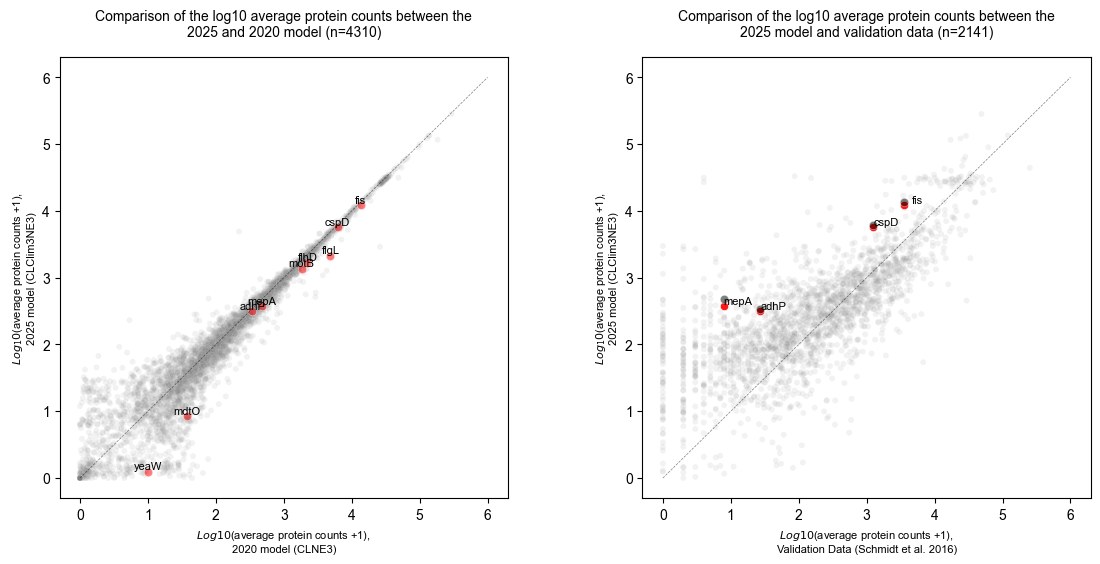

In [6]:
# edit the plot out file as needed
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/counts_comparison_plot__{proteins_of_interest}__{current_sequence}_{CLNE_sequence}.png"

validaiton_column = 'Log10 Validation Data Average Monomer Counts'

# ok now make a 2 by 2 plot

def make_counts_comparison_with_upper_HL_change_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row]
    
    # plot all of the proteins 
    sns.scatterplot(data=whole_df, x=whole_df[CLNE_new_name], y=whole_df[CLClimNE_new_name], color='grey', size=0.1, alpha=0.1, ax=ax, )
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df, x=interest_df[CLNE_new_name], y=interest_df[CLClimNE_new_name], color='red', alpha=0.5, ax=ax, )
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df['common_name'].unique()):
        # get the index of the protein:
        index = interest_df[interest_df['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df[CLNE_new_name][index]
        y = interest_df[CLClimNE_new_name][index]
        # plot the common name:
        ax.text(x, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
    
    # Plot specs:
    ax.set_title(f'Comparison of the log10 average protein counts between the\n2025 and 2020 model (n={whole_df.shape[0]})', fontsize=10, pad=15, )
    ax.set_xlabel(f'$Log10$(average protein counts +1),\n2020 model ({CLNE_sequence})', fontsize=8, color="black", )
    ax.set_ylabel(f'$Log_10$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=8, color="black", )
    
    # add a legend:
    #legend_labels = [f'all proteins (n={whole_df.shape[0]})', f'proteins with the largest +$\\Delta$\n in half life (n={interest_df.shape[0]})']
    #handles, _ = ax.get_legend_handles_labels()
    #ax.legend(handles=handles, labels=legend_labels, loc='upper left', fontsize=8, frameon=False, markerscale=2)
    ax.legend()
    ax.get_legend().set_visible(False)
 
# now make a plot for the validation comparison: 
def make_counts_comparison_with_upper_HL_change_validation_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row]
    
    # clean up the data: 
    x_col = 'Log10 Validation Data Average Monomer Counts'
    y_col = CLClimNE_new_name
    y_col2 = CLNE_new_name

    # remove proteins that have "None" in their y_col: 
    whole_df_to_plot = whole_df[whole_df[x_col].notna()]
    interest_df_to_plot = interest_df[interest_df[x_col].notna()]

    
    # plot all of the proteins 
    sns.scatterplot(data=whole_df_to_plot, x=whole_df_to_plot[x_col], y=whole_df_to_plot[y_col], color='grey', size=.1, alpha=0.1, ax=ax,)
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col], color='red', alpha=0.9, ax=ax)
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col2], color='black', alpha=0.5, ax=ax)
    
    # add a y=x dotted line:
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df_to_plot['common_name'].unique()):
        # get the index of the protein:
        index = interest_df_to_plot[interest_df_to_plot['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df_to_plot[x_col][index]
        y = interest_df_to_plot[y_col][index]
        # plot the common name:
        ax.text(x+.2, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
        
        # also make a line between the two: 
        y2 = interest_df_to_plot[y_col2][index]
        difference = y - y2
        if abs(difference) > 0.2:
            dx = x-x
            dy = y - y2
            #ax.arrow([x, x], [y, y2], color='red', linewidth=.5, alpha=0.5)
            ax.arrow(x, y2, dx, dy, color='red', linewidth=.5, alpha=0.5, head_width=0.1, head_length=0.15, length_includes_head=True)
            
        
        # if difference < -0.2:
        #     dx = x-x
        #     dy = y - y2
        #     #ax.arrow([x, x], [y, y2], color='red', linewidth=.5, alpha=0.5)
        #     ax.arrow(x, y2, dx, dy, color='blue', linewidth=.5, alpha=0.5, head_width=0.1, head_length=0.15, length_includes_head=True)
    
    # Plot specs:
    ax.set_title(f'Comparison of the log10 average protein counts between the\n2025 model and validation data (n={whole_df_to_plot.shape[0]})', fontsize=10, pad=15, )
    ax.set_xlabel(f'$Log10$(average protein counts +1),\nValidation Data (Schmidt et al. 2016)', fontsize=8, color="black", )
    ax.set_ylabel(f'$Log_10$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=8, color="black", )
    ax.legend()
    ax.get_legend().set_visible(False)



# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
fig, axes = plt.subplots(figsize=(11,5),  nrows=1, ncols=2, )
fig.tight_layout()

# plot the plots 
make_counts_comparison_with_upper_HL_change_data(0,0, combined_df, interest_df)
make_counts_comparison_with_upper_HL_change_validation_data(1,1, combined_df, interest_df)

fig.subplots_adjust(wspace=0.3, hspace=0.4)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# make a plots that just shows all proteins and how they move

1. if their counts improve towards the y=x line, make them blue, and if they decrease, red. If their half life increases, make the outside darkblue, and if it decreases, darkred. Do not show the original grey dot on the right graph 
2. on the left graph, highlight again increase vs decrease in half life via the rim (same half lives get a grey rim). ON the validation graph, make the dots green if they move closer to y=x, red if they move further from y=x, and salmon if they just barely move in the wrong direction, and same with green. still highlight the rims accordingly
3. make a graph of everything that moves in the right direciton highlighted
4. make a graph of everything that moves in the wrong direction highlighted
5. make a graph of everything that had an increase in half life only (and do not show the background dots). color code these based on 
6. make a graph of everything that had a decrease in half life only 
7. make a graph of everything that had no change in half life 
8. maybe make a plot of the best changes towards the validation data? and have them labeled?

CONSIDER doing a 3x2 spread, where R to L is the proteins with an increase in half life only plotted, then no change in half life, then decrease in half life, and then on the lower row, same order, but the validation plots instead 

## add new rows to the combined_df

In [7]:
# add a HL difference column and PC_difference column: 
combined_df["HL_difference"] = combined_df["new_half_life"] - combined_df["original_half_life"]

# PC_difference column:
combined_df["PC_difference"] = combined_df[CLClimNE_new_name] - combined_df[CLNE_new_name]

# assign accordingly:
combined_df["HL_category"] = ""
combined_df["PC_category"] = ""
for row in combined_df.index:
    HL_val = combined_df.loc[row, "HL_difference"] 
    PC_val = combined_df.loc[row, "PC_difference"]
    
    if HL_val > 0:
        combined_df.loc[row, "HL_category"] = "increase"
    elif HL_val < 0:
        combined_df.loc[row, "HL_category"] = "decrease"
    elif HL_val == 0:
        combined_df.loc[row, "HL_category"] = "NA"
        
    if PC_val > 0:
        combined_df.loc[row, "PC_category"] = "increase"
    elif PC_val < 0:
        combined_df.loc[row, "PC_category"] = "decrease"
    elif PC_val == 0:
        combined_df.loc[row, "PC_category"] = "NA"
    
# also do something with the validation data! get the absolute changes!
counts_2020 = f"{CLNE_sequence} counts"
combined_df[counts_2020] = 10**combined_df[CLNE_new_name] - 1
counts_2025 = f"{current_sequence} counts"
combined_df[counts_2025] = 10**combined_df[CLClimNE_new_name] - 1
combined_df["validation counts"] = 10**combined_df["Log10 Validation Data Average Monomer Counts"] - 1

combined_df["original_validation_diff"] = abs(combined_df[counts_2020] - combined_df["validation counts"])
combined_df["new_validation_diff"] = abs(combined_df[counts_2025] - combined_df["validation counts"])

combined_df["validation_difference"] = abs(combined_df["original_validation_diff"] - combined_df["new_validation_diff"])

# todo: something does not feel right here... hmm gotta figure this out!

# combined_df["original_validation_diff"] = abs(combined_df[CLNE_new_name] - combined_df['Log10 Validation Data Average Monomer Counts'])
# combined_df["new_validation_diff"] = abs(combined_df[CLClimNE_new_name] - combined_df['Log10 Validation Data Average Monomer Counts'])
    
combined_df["validation_change"] = ""
for row in combined_df.index:
    old_val = combined_df.loc[row, "original_validation_diff"]
    new_val = combined_df.loc[row, "new_validation_diff"]
    validation_value = combined_df.loc[row, 'Log10 Validation Data Average Monomer Counts']
    
    if validation_value is None:
        combined_df.loc[row, "validation_change"] = "NA"
    elif new_val < old_val:
        combined_df.loc[row, "validation_change"] = "closer" # as in got better
    elif new_val > old_val:
        combined_df.loc[row, "validation_change"] = "further"
    elif new_val == old_val:
        combined_df.loc[row, "validation_change"] = "same"
        




        

combined_df

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE3 Average Monomer Counts,Log10 CLClim3NE3 Average Monomer Counts,Log10 Validation Data Average Monomer Counts,HL_difference,PC_difference,HL_category,PC_category,CLNE3 counts,CLClim3NE3 counts,validation counts,original_validation_diff,new_validation_diff,validation_difference,validation_change
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,501.707893,600.0,plsC,2.249742,2.227345,1.643453,-98.292107,-0.022397,decrease,decrease,176.722394,167.789208,43.0,133.722394,124.789208,8.933186,closer
1,1-PFK-MONOMER,766.256894,600.0,fruK,1.958683,1.829091,1.755875,166.256894,-0.129592,increase,decrease,89.924940,66.466999,56.0,33.92494,10.466999,23.457941,closer
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,600.000000,600.0,panE,2.166982,2.313671,1.414973,0.000000,0.146689,NA,increase,145.886665,204.906987,25.0,120.886665,179.906987,59.020322,further
3,2-ISOPROPYLMALATESYN-MONOMER,276.924332,600.0,leuA,3.652449,3.587425,3.43329,-323.075668,-0.065024,decrease,decrease,4491.096137,3866.455770,2711.0,1780.096137,1155.45577,624.640367,closer
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,493.397050,600.0,ubiE,2.673989,2.636785,2.968483,-106.602950,-0.037204,decrease,decrease,471.051238,432.296706,929.0,457.948762,496.703294,38.754531,further
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305,YTFR-MONOMER,654.149344,600.0,ytfR,1.282915,1.216184,0.0,54.149344,-0.066731,increase,decrease,18.182944,15.450680,0.0,18.182944,15.45068,2.732265,closer
4306,YTFT-MONOMER,600.000000,600.0,ytfT,1.298818,1.178662,None,0.000000,-0.120156,NA,decrease,18.898385,14.089046,NaN,NaN,NaN,NaN,NA
4307,ZNUA-MONOMER,638.129701,600.0,znuA,2.829617,2.909994,2.638489,38.129701,0.080377,increase,increase,674.486299,811.819214,434.0,240.486299,377.819214,137.332915,further
4308,ZNUB-MONOMER,600.000000,600.0,znuB,1.797419,1.754456,None,0.000000,-0.042963,NA,decrease,61.721847,55.814061,NaN,NaN,NaN,NaN,NA


In [8]:
# make new directory 

## Plot 1: shows everything

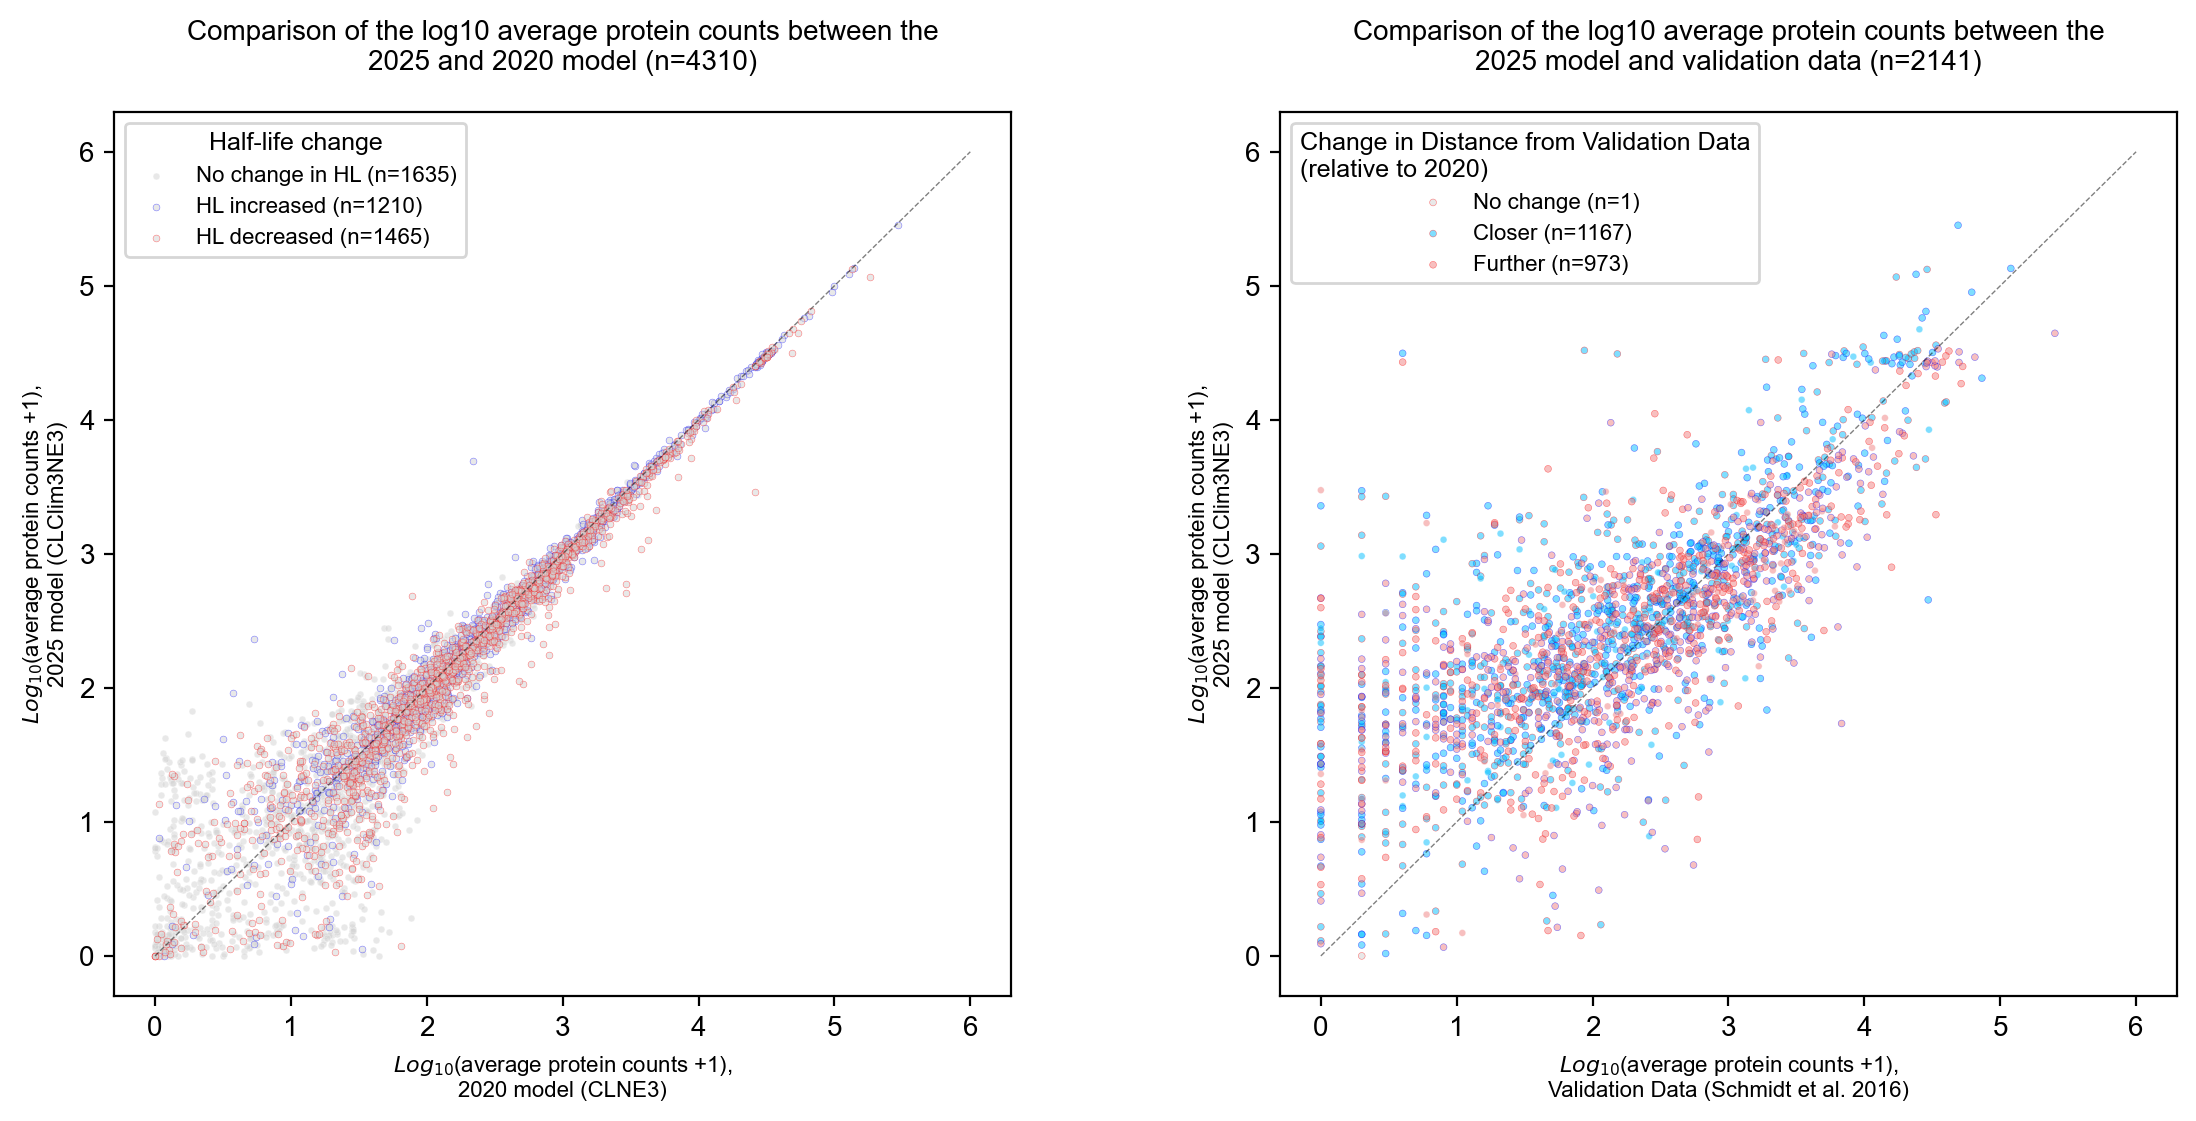

In [9]:
# edit the plot out file as needed
plot_type = "everything_moving"
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/protein_count_comparison_and_validation_plots/counts_comparison_plot__{plot_type}__{current_sequence}_{CLNE_sequence}.png"

validaiton_column = 'Log10 Validation Data Average Monomer Counts'
    
def make_counts_comparison_with_2020_model(row, col,  whole_df):
    ax = axes[row]
    
    HL_color_map = {
        "increase": "blue",
        "decrease": "red",
        "NA": "white",
    }
    
    PC_color_map = {
        "increase": "deepskyblue",
        "decrease": "lightcoral",
        "NA": "white",
    }
    
    

    # Get x and y values
    x = whole_df[CLNE_new_name]
    y = whole_df[CLClimNE_new_name]

    # Get face and edge colors from maps
    facecolors = whole_df["PC_category"].map(PC_color_map)
    edgecolors = whole_df["HL_category"].map(HL_color_map)

    # Plot each point manually with customized colors
    #ax.scatter(x, y, c="grey", edgecolors=edgecolors, linewidth=0.5, alpha=0.8, s=20)
    
    HL_counts = whole_df["HL_category"].value_counts()
    HL_labels = {
    "NA": f"No change in HL (n={HL_counts['NA']})",
    "increase": f"HL increased (n={HL_counts['increase']})",
    "decrease": f"HL decreased (n={HL_counts['decrease']})",
    }

    # Plot in specific order
    for hl_status in ["NA", "increase", "decrease"]:
        sub_df = whole_df[whole_df["HL_category"] == hl_status]
    
        ax.scatter(
            sub_df[CLNE_new_name],
            sub_df[CLClimNE_new_name],
            label=HL_labels[hl_status],
            c="lightgrey",
            edgecolors=HL_color_map[hl_status],
            linewidth=0.2,
            alpha=0.5,
            s=6,
        )

    # Add the single legend
    ax.legend(title="Half-life change", loc="upper left", fontsize=8, title_fontsize=9)

    # Plot y = x line
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    # Axis titles
    ax.set_title(
        f'Comparison of the log10 average protein counts between the\n2025 and 2020 model (n={whole_df.shape[0]})',
        fontsize=10, pad=15)
    ax.set_xlabel(
        f'$Log_{{10}}$(average protein counts +1),\n2020 model ({CLNE_sequence})',
        fontsize=8, color="black")
    ax.set_ylabel(
        f'$Log_{{10}}$(average protein counts +1),\n2025 model ({current_sequence})',
        fontsize=8, color="black")
    
    # # Add legend to explain HL differences (edge color)
    # legend1 = ax.legend(title="Half-life change", loc="upper left", fontsize=8, title_fontsize=9)
    # ax.add_artist(legend1)
    # # Custom legend
    # hl_counts = whole_df["HL_category"].value_counts()
    # hl_increase = hl_counts.get("increase", 0)
    # hl_decrease = hl_counts.get("decrease", 0)
    # hl_same = hl_counts.get("NA", 0)
    # 
    # legend_labels = [
    #     f"HL increase: {hl_increase}",
    #     f"HL decrease: {hl_decrease}",
    #     f"HL unchanged: {hl_same}"
    # ]
    # for label in legend_labels:
    #     ax.plot([], [], 'o', label=label, color='white', markeredgecolor='black', markersize=6)

    
 
# now make a plot for the validation comparison: 
def make_counts_comparison_with_validation_data(row, col, whole_df):
    # define the axes:
    ax = axes[row]
    
    # clean up the data: 
    x_col = 'Log10 Validation Data Average Monomer Counts'
    y_col = CLClimNE_new_name
    y_col2 = CLNE_new_name

    # remove proteins that have "None" in their y_col: 
    whole_df_to_plot = whole_df[whole_df[x_col].notna()]

    
    # make the mappings 
    HL_color_map = {
        "increase": "blue",
        "decrease": "red",
        "NA": "white",
    }
    
    PC_color_map = {
        "increase": "deepskyblue",
        "decrease": "lightcoral",
        "NA": "white",
    }

    validation_color_map = {
        "closer": "deepskyblue",
        "further": "lightcoral",
        "same": "lightgrey",
    }

    # Get face and edge colors from maps
    facecolors = whole_df_to_plot["validation_change"].map(validation_color_map)
    edgecolors = whole_df_to_plot["HL_category"].map(HL_color_map)

    # make the plot: 
    VC_counts = whole_df_to_plot["validation_change"].value_counts()
    VC_labels = {
    "same": f"No change (n={VC_counts['same']})",
    "closer": f"Closer (n={VC_counts['closer']})",
    "further": f"Further (n={VC_counts['further']})",
    }
    
    # Plot in specific order
    for change_status in ["same", "closer", "further"]:
        sub_df = whole_df_to_plot[whole_df_to_plot["validation_change"] == change_status]
    
        ax.scatter(
            sub_df[x_col],
            sub_df[y_col],
            label=VC_labels[change_status],
            c=validation_color_map[change_status],
            edgecolors=edgecolors,
            linewidth=0.2,
            alpha=0.5,
            s=6,
        )
    
    
    
    # Add the legend
    ax.legend(title="Change in Distance from Validation Data\n(relative to 2020)", loc="upper left", fontsize=8, title_fontsize=9)
    
    
    # add a y=x dotted line:
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    
    
    
    
    
    # Plot specs:
    ax.set_title(f'Comparison of the log10 average protein counts between the\n2025 model and validation data (n={whole_df_to_plot.shape[0]})', fontsize=10, pad=15, )
    ax.set_xlabel(f'$Log_{{10}}$(average protein counts +1),\nValidation Data (Schmidt et al. 2016)', fontsize=8, color="black", )
    ax.set_ylabel(f'$Log_{{10}}$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=8, color="black", )




# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
fig, axes = plt.subplots(figsize=(11,5),  nrows=1, ncols=2, dpi=200)
fig.tight_layout()

# plot the plots 
make_counts_comparison_with_2020_model(0,0, combined_df)
make_counts_comparison_with_validation_data(1,1, combined_df)

fig.subplots_adjust(wspace=0.3, hspace=0.4)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


## plot showing the increase, decrease, and no change in half life value outcomes

closer
further
same
closer
further
closer
further
same
closer
further


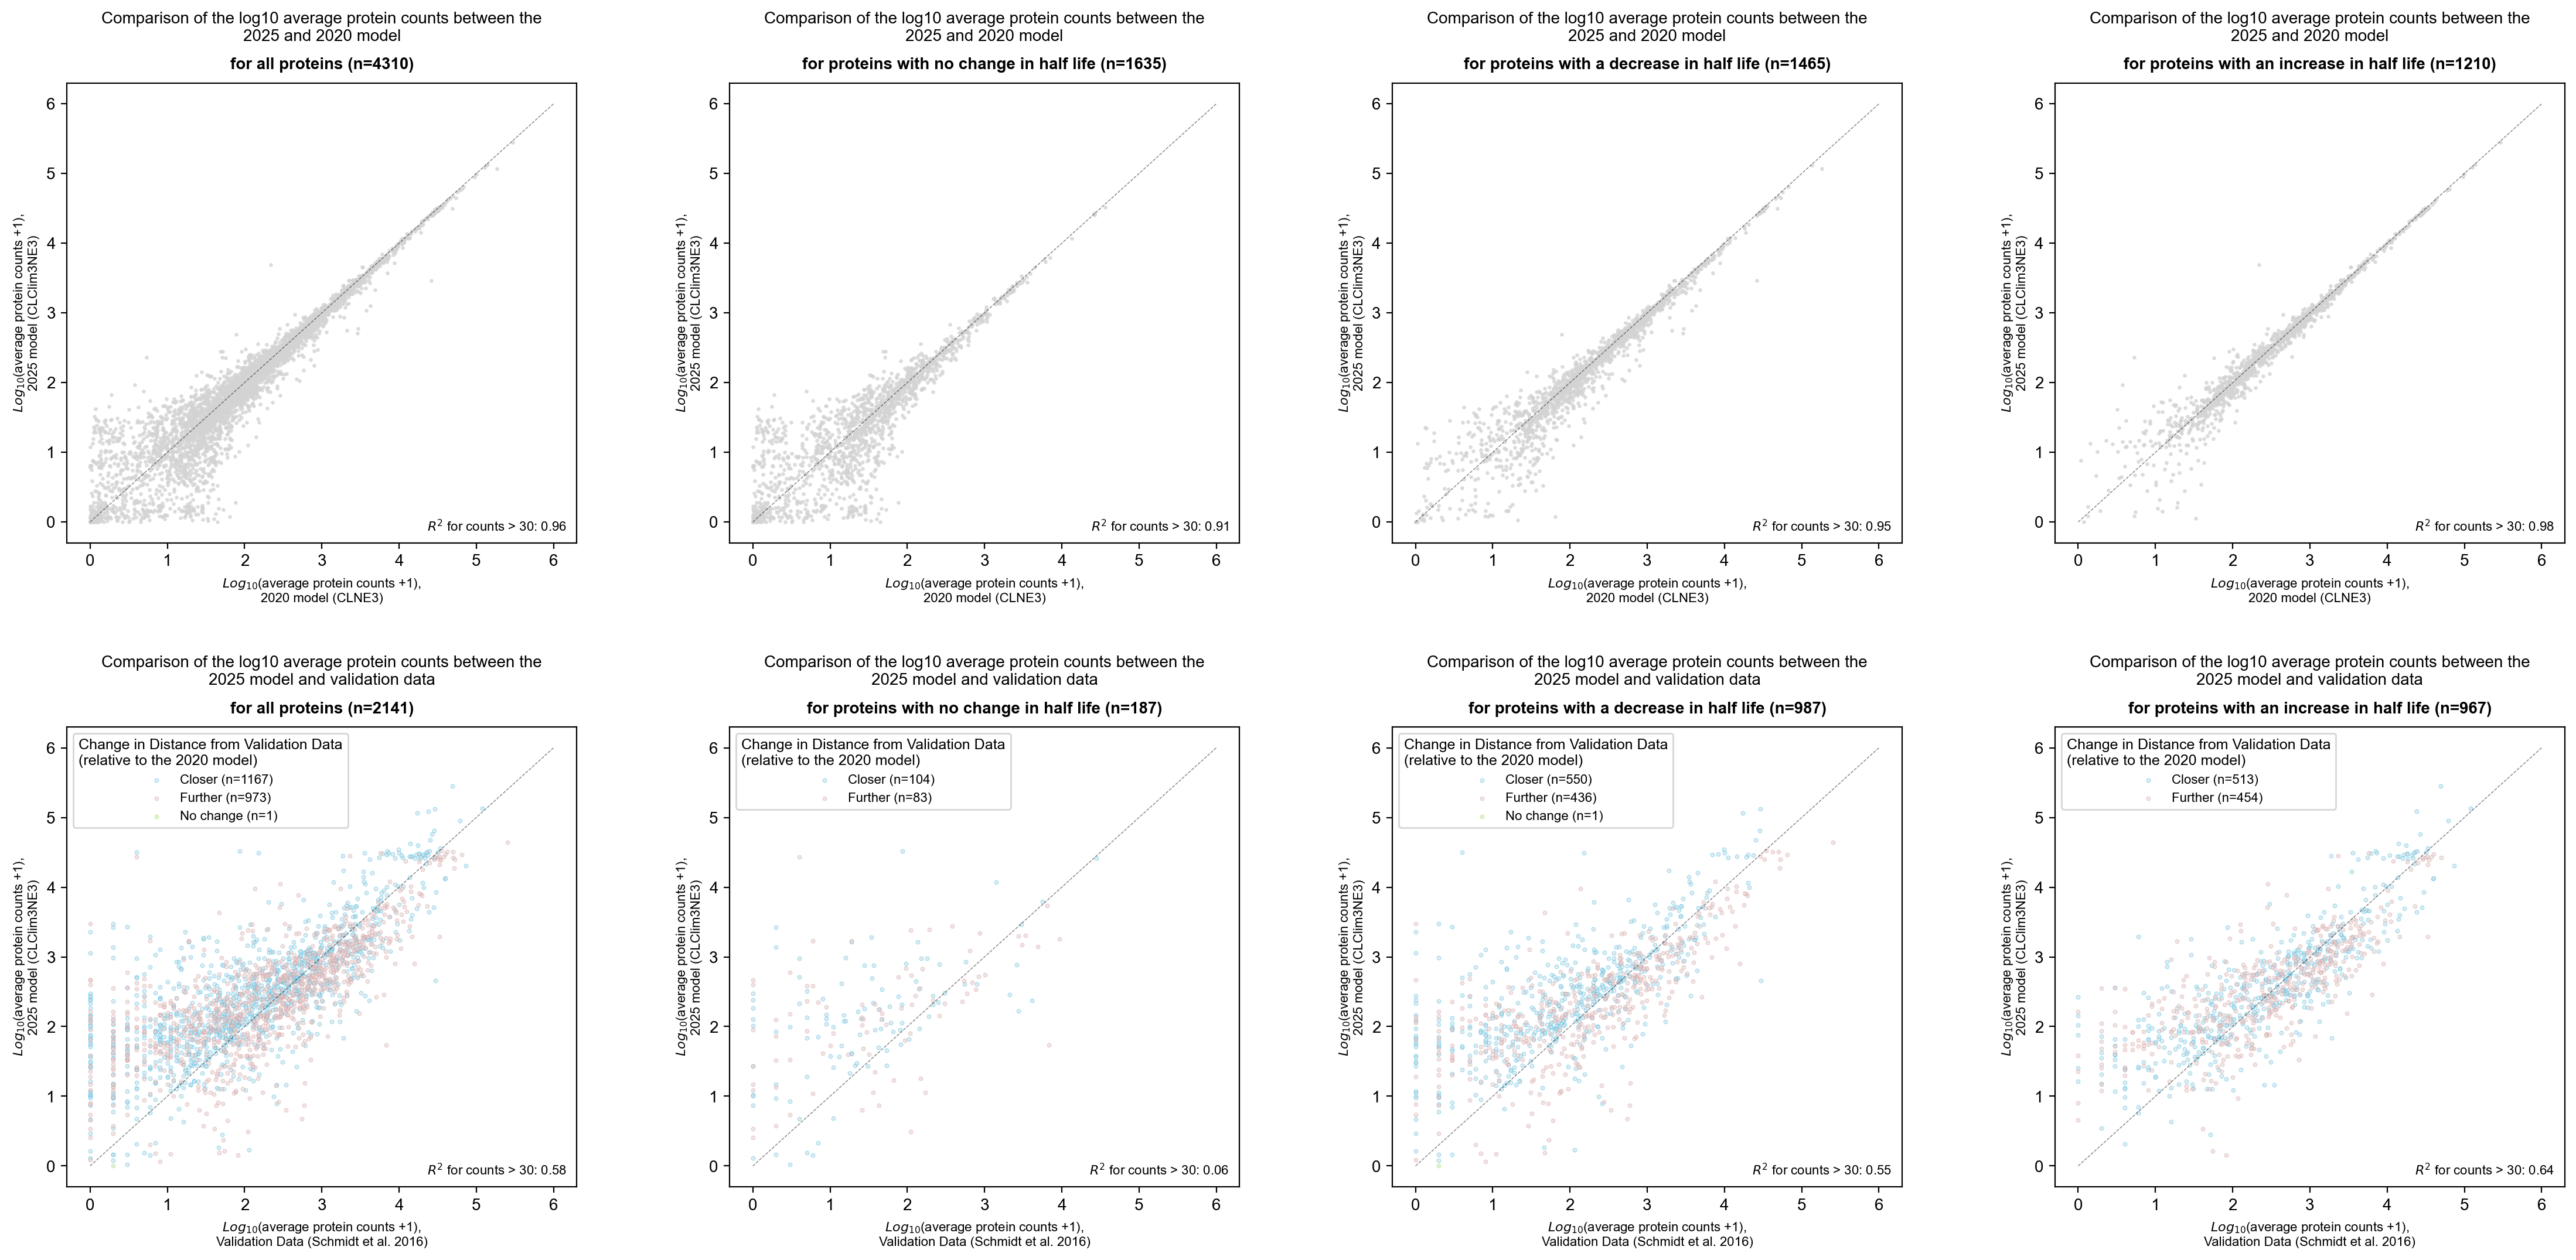

In [10]:
# edit the plot out file as needed
plot_type = "inc_dec_same_separate"
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/protein_count_comparison_and_validation_plots/counts_comparison_plot__{plot_type}__{current_sequence}_{CLNE_sequence}.png"

validaiton_column = 'Log10 Validation Data Average Monomer Counts'

    
def make_counts_comparison_with_2020_model(row, col, whole_df, plot_type):
    ax = axes[row, col]
    
    HL_color_map = {
        "increase": "blue",
        "decrease": "red",
        "NA": "white",
    }
    
    # Get x and y values
    x = whole_df[CLNE_new_name]
    y = whole_df[CLClimNE_new_name]

    # Plot each point manually with customized colors
    ax.scatter(x, y, c="lightgrey", linewidth=.1, alpha=0.8, s=5)


    # Plot y = x line
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    # Axis titles
    ax.set_title(
        f'Comparison of the log10 average protein counts between the\n2025 and 2020 model\n',
        fontsize=10, pad=15)
    ax.text(0.5, 1.03, f'{plot_type} (n={whole_df.shape[0]})', fontsize=10,fontweight='bold', ha='center', transform=ax.transAxes)
    
    ax.set_xlabel(
        f'$Log_{{10}}$(average protein counts +1),\n2020 model ({CLNE_sequence})',
        fontsize=8, color="black")
    ax.set_ylabel(
        f'$Log_{{10}}$(average protein counts +1),\n2025 model ({current_sequence})',
        fontsize=8, color="black")
    
    # compute the rsquared value:
    above_30_idx = (x > np.log10(30 + 1)) & (y > np.log10(30 + 1))
    x_above_30 = x[above_30_idx];y_above_30 = y[above_30_idx]
    r_squared_30_above = r2_score(x_above_30, y_above_30)
    ax.text(
    0.98, 0.02,  # x and y position (bottom-right corner)
    f"$R^2$ for counts > 30: {r_squared_30_above:.2f}", 
    transform=ax.transAxes,  
    ha='right', va='bottom',  
    fontsize=8, color='black')
    
    ax.grid(False)
    
 
# now make a plot for the validation comparison: 
def make_counts_comparison_with_validation_data(row, col, whole_df, plot_type):
    # define the axes:
    ax = axes[row, col]
    
    # clean up the data: 
    x_col = 'Log10 Validation Data Average Monomer Counts'
    y_col = CLClimNE_new_name

    # remove proteins that have "None" in their y_col: 
    whole_df_to_plot = whole_df[whole_df[x_col].notna()]

    validation_color_map = {
        "closer": "deepskyblue",
        "further": "lightcoral",
        "same": "lawngreen",
    }

    # make the plot: 
    VC_counts = whole_df_to_plot["validation_change"].value_counts()
    VC_labels = {}
    if "same" in VC_counts:
        VC_labels["same"] = f"No change (n={VC_counts['same']})"
    if "closer" in VC_counts:
        VC_labels["closer"] = f"Closer (n={VC_counts['closer']})"
    if "further" in VC_counts:
        VC_labels["further"] = f"Further (n={VC_counts['further']})"
    
    # Plot in specific order
    for change_status in VC_counts.keys():
        print(change_status)
        sub_df = whole_df_to_plot[whole_df_to_plot["validation_change"] == change_status]
    
        ax.scatter(
            sub_df[x_col],
            sub_df[y_col],
            label=VC_labels[change_status],
            c="lightgrey",
            edgecolor=validation_color_map[change_status],
            linewidth=0.3,
            alpha=0.5,
            s=6,
        )
    
    # compute the rsquared value:
    x = whole_df_to_plot[x_col]
    y = whole_df_to_plot[y_col]
    above_30_idx =(x > np.log10(30 + 1)) & (y > np.log10(30 + 1))
    x_above_30 = x[above_30_idx];y_above_30 = y[above_30_idx]
    r_squared_30_above = r2_score(x_above_30, y_above_30)
    ax.text(
    0.98, 0.02,  # x and y position (bottom-right corner)
    f"$R^2$ for counts > 30: {r_squared_30_above:.2f}", 
    transform=ax.transAxes,  
    ha='right', va='bottom',  
    fontsize=8, color='black')
    
    # Add the legend
    ax.legend(title=f"Change in Distance from Validation Data\n(relative to the 2020 model)", loc="upper left", fontsize=8, title_fontsize=9)
    
    
    # add a y=x dotted line:
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    ax.grid(False)
    
    
    # Plot specs:
    ax.set_title(f'Comparison of the log10 average protein counts between the\n2025 model and validation data\n', fontsize=10, pad=15, )
    ax.text(0.5, 1.03, f'{plot_type} (n={whole_df_to_plot.shape[0]})', fontsize=10,fontweight='bold', ha='center', transform=ax.transAxes)
    

    ax.set_xlabel(f'$Log_{{10}}$(average protein counts +1),\nValidation Data (Schmidt et al. 2016)', fontsize=8, color="black", )
    ax.set_ylabel(f'$Log_{{10}}$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=8, color="black", )




# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
fig, axes = plt.subplots(figsize=(22,10),  nrows=2, ncols=4, dpi=200)
fig.tight_layout()

# plot the plots 

# plots with all data
make_counts_comparison_with_2020_model(0,0, combined_df, "for all proteins" )
make_counts_comparison_with_validation_data(1,0, combined_df, "for all proteins")

# plots for proteins with no change in half life:
no_HL_change_df = combined_df[combined_df["HL_category"]=="NA"]
make_counts_comparison_with_2020_model(0,1, no_HL_change_df, "for proteins with no change in half life" )
make_counts_comparison_with_validation_data(1,1, no_HL_change_df, "for proteins with no change in half life")

# proteins with a decrease in half life value: 
decrease_HL_df = combined_df[combined_df["HL_category"]=="decrease"]
make_counts_comparison_with_2020_model(0,2, decrease_HL_df, "for proteins with a decrease in half life" )
make_counts_comparison_with_validation_data(1,2, decrease_HL_df, "for proteins with a decrease in half life")

# proteins with an increase in half life value: 
increase_HL_df = combined_df[combined_df["HL_category"]=="increase"]
make_counts_comparison_with_2020_model(0,3, increase_HL_df, "for proteins with an increase in half life" )
make_counts_comparison_with_validation_data(1,3, increase_HL_df, "for proteins with an increase in half life")

fig.subplots_adjust(wspace=0.3, hspace=0.4)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


## plot with the distances plotted, as well as a histogram of their changes in the direction

have the r2 for the 2020 model vs now and the 2025 model r2 showing 
should I highlight the increase and decrease of of half life on the rim again? Yes



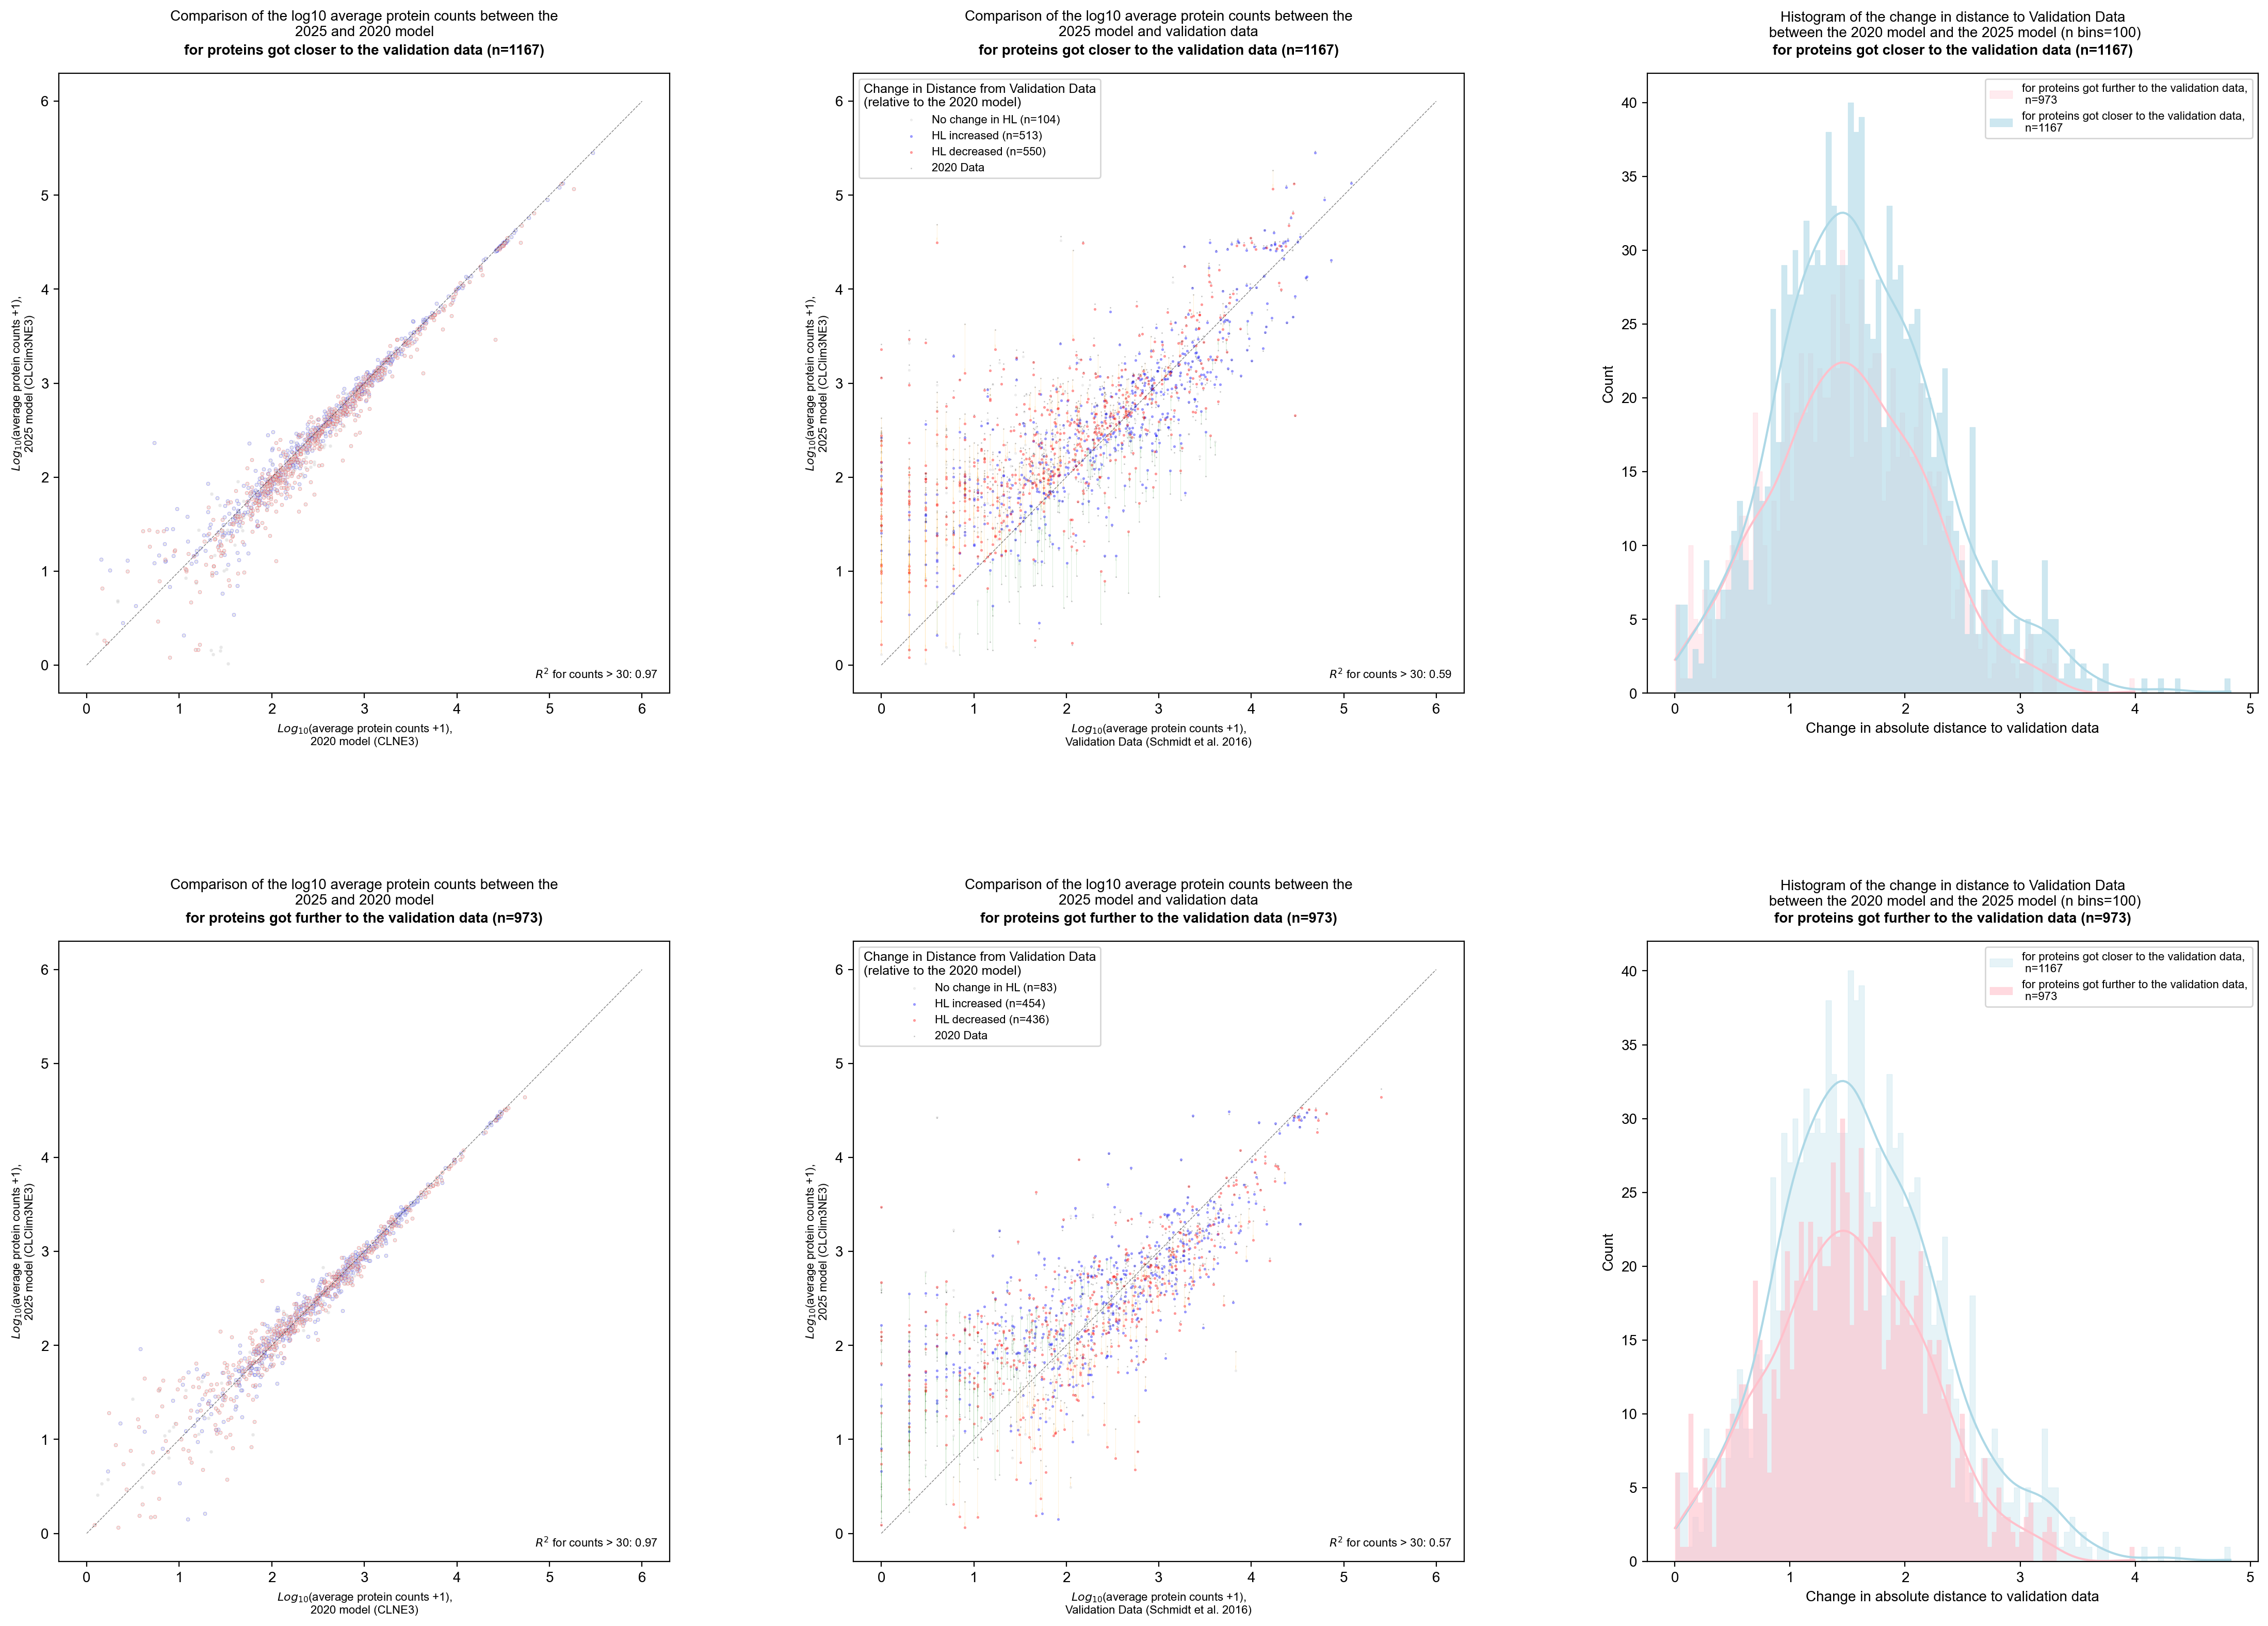

In [11]:
# edit the plot out file as needed
plot_type = "closest_and_furthest_sep"
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/protein_count_comparison_and_validation_plots/counts_comparison_plot__{plot_type}__{current_sequence}_{CLNE_sequence}.png"

validaiton_column = 'Log10 Validation Data Average Monomer Counts'

    
def make_counts_comparison_with_2020_model(row, col, whole_df, plot_type):
    ax = axes[row, col]
    
    HL_color_map = {
        "increase": "blue",
        "decrease": "red",
        "NA": "white",
    }

    
    HL_counts = whole_df["HL_category"].value_counts()
    HL_labels = {
    "NA": f"No change in HL (n={HL_counts['NA']})",
    "increase": f"HL increased (n={HL_counts['increase']})",
    "decrease": f"HL decreased (n={HL_counts['decrease']})",
    }

    # Plot in specific order
    for hl_status in ["NA", "increase", "decrease"]:
        sub_df = whole_df[whole_df["HL_category"] == hl_status]
    
        ax.scatter(
            sub_df[CLNE_new_name],
            sub_df[CLClimNE_new_name],
            label=HL_labels[hl_status],
            c="lightgrey",
            edgecolors=HL_color_map[hl_status],
            linewidth=0.2,
            alpha=0.5,
            s=6,
        )


    # Plot y = x line
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    # Axis titles
    ax.set_title(
        f'Comparison of the log10 average protein counts between the\n2025 and 2020 model\n',
        fontsize=10, pad=15)
    ax.text(0.5, 1.03, f'{plot_type} (n={whole_df.shape[0]})', fontsize=10,fontweight='bold', ha='center', transform=ax.transAxes)
    
    ax.set_xlabel(
        f'$Log_{{10}}$(average protein counts +1),\n2020 model ({CLNE_sequence})',
        fontsize=8, color="black")
    ax.set_ylabel(
        f'$Log_{{10}}$(average protein counts +1),\n2025 model ({current_sequence})',
        fontsize=8, color="black")
    
    # compute the rsquared value:
    x = whole_df[CLNE_new_name]
    y = whole_df[CLClimNE_new_name]
    above_30_idx = (x > np.log10(30 + 1)) & (y > np.log10(30 + 1))
    x_above_30 = x[above_30_idx];y_above_30 = y[above_30_idx]
    r_squared_30_above = r2_score(x_above_30, y_above_30)
    ax.text(
    0.98, 0.02,  # x and y position (bottom-right corner)
    f"$R^2$ for counts > 30: {r_squared_30_above:.2f}", 
    transform=ax.transAxes,  
    ha='right', va='bottom',  
    fontsize=8, color='black')
    
    ax.grid(False)
    
 
# now make a plot for the validation comparison: 
def make_counts_comparison_with_validation_data(row, col, whole_df, plot_type, plot_2020=0):
    # define the axes:
    ax = axes[row, col]
    
    # clean up the data: 
    x_col = 'Log10 Validation Data Average Monomer Counts'
    y_col = CLClimNE_new_name
    y_col2 = CLNE_new_name

    # remove proteins that have "None" in their y_col: 
    whole_df_to_plot = whole_df[whole_df[x_col].notna()]
    
    HL_color_map = {
        "increase": "blue",
        "decrease": "red",
        "NA": "lightgrey",
    }

    
        
    HL_counts = whole_df_to_plot["HL_category"].value_counts()
    HL_labels = {
    "NA": f"No change in HL (n={HL_counts['NA']})",
    "increase": f"HL increased (n={HL_counts['increase']})",
    "decrease": f"HL decreased (n={HL_counts['decrease']})",
    }

    # Plot in specific order
    for hl_status in ["NA", "increase", "decrease"]:
        sub_df = whole_df_to_plot[whole_df_to_plot["HL_category"] == hl_status]
    
        ax.scatter(
            sub_df[x_col],
            sub_df[y_col],
            label=HL_labels[hl_status],
            c=HL_color_map[hl_status],
            edgecolors=None,
            linewidth=0.1,
            alpha=0.4,
            s=3,
        )
        
    if plot_2020==1:
        sns.scatterplot(data=whole_df_to_plot, x=whole_df_to_plot[x_col], y=whole_df_to_plot[y_col2], color='black', alpha=0.25, ax=ax, label="2020 Data", s=1)
        # plot the common name of the proteins of interest:
        for i, name in enumerate(whole_df_to_plot['common_name'].unique()):
            # get the index of the protein:
            index = whole_df_to_plot[whole_df_to_plot['common_name'] == name].index[0]
            # get the x and y values:
            x = whole_df_to_plot[x_col][index]
            y = whole_df_to_plot[y_col][index]
            
            # also make a line between the two: 
            y2 = whole_df_to_plot[y_col2][index]
            difference = y - y2
            if difference > 0.1:
                dx = x-x
                dy = y - y2
                ax.arrow(x, y2, dx, dy, color='green', linewidth=.1, alpha=0.2, head_width=0.01, head_length=0.05, length_includes_head=True)
                
            if difference < -0.1:
                dx = x-x
                dy = y - y2
                ax.arrow(x, y2, dx, dy, color='orange', linewidth=.1, alpha=0.2, head_width=0.01, head_length=0.05, length_includes_head=True)
    
    # compute the rsquared value:
    x = whole_df_to_plot[x_col]
    y = whole_df_to_plot[y_col]
    above_30_idx =(x > np.log10(30 + 1)) & (y > np.log10(30 + 1))
    x_above_30 = x[above_30_idx];y_above_30 = y[above_30_idx]
    r_squared_30_above = r2_score(x_above_30, y_above_30)
    ax.text(
    0.98, 0.02,  # x and y position (bottom-right corner)
    f"$R^2$ for counts > 30: {r_squared_30_above:.2f}", 
    transform=ax.transAxes,  
    ha='right', va='bottom',  
    fontsize=8, color='black')
    
    # Add the legend
    ax.legend(title=f"Change in Distance from Validation Data\n(relative to the 2020 model)", loc="upper left", fontsize=8, title_fontsize=9)
    
    
    # add a y=x dotted line:
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    ax.grid(False)
    
    
    # Plot specs:
    ax.set_title(f'Comparison of the log10 average protein counts between the\n2025 model and validation data\n', fontsize=10, pad=15, )
    ax.text(0.5, 1.03, f'{plot_type} (n={whole_df_to_plot.shape[0]})', fontsize=10,fontweight='bold', ha='center', transform=ax.transAxes)
    

    ax.set_xlabel(f'$Log_{{10}}$(average protein counts +1),\nValidation Data (Schmidt et al. 2016)', fontsize=8, color="black", )
    ax.set_ylabel(f'$Log_{{10}}$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=8, color="black", )


def make_histogram_of_differences(row, col, whole_df, plot_type, color_first, opposing_df, plot_type_opposing, op_color):
    ax = axes[row, col]
    x_col = 'Log10 Validation Data Average Monomer Counts'
    
    # remove proteins that have "None" in their y_col: 
    whole_df_to_plot = whole_df[whole_df[x_col].notna()]
    whole_opposition_df = opposing_df[opposing_df[x_col].notna()]
    
    # calculate the log10 of the validation difference:
    validation_diff = pd.to_numeric(whole_df_to_plot["validation_difference"], errors='coerce')
    log_10_validation_difference = np.log10(validation_diff + 1)
    validation_op_diff = pd.to_numeric(whole_opposition_df["validation_difference"], errors='coerce')
    log_10_validation_op_difference = np.log10(validation_op_diff + 1)
    
    bins = 100
    #sns.histplot(log_10_validation_difference, bins=bins, color='skyblue', kde=False, ax=ax)
    
    sns.histplot(log_10_validation_op_difference,  bins=bins, color=op_color, alpha=0.3, kde=True, element='step',
         label=f'{plot_type_opposing},\n n={log_10_validation_op_difference.shape[0]}', linewidth=.1, ax=ax)
    sns.histplot(log_10_validation_difference, bins=bins,  color=color_first, alpha=0.6, kde=True, element='step',
         label=f'{plot_type},\n n={log_10_validation_difference.shape[0]}', linewidth=.1, ax=ax)
    ax.legend(loc='best', fontsize=8, frameon=True, markerscale=2)
    
    ax.set_title(f"Histogram of the change in distance to Validation Data\n between the 2020 model and the 2025 model (n bins={bins})", fontsize=10, pad=25, )
    ax.text(0.5, 1.03, f'{plot_type} (n={whole_df_to_plot.shape[0]})', fontsize=10,fontweight='bold', ha='center', transform=ax.transAxes)
    
    ax.set_xlabel("Change in absolute distance to validation data")
    
    ax.grid(False)
    

    
    


# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
fig, axes = plt.subplots(figsize=(22,15),  nrows=2, ncols=3, dpi=200)
fig.tight_layout()

# plot the plots 

# plot with the proteins that get closer to the validation data:
closer_VC_df = combined_df[combined_df["validation_change"]=="closer"]
closer_name = "for proteins got closer to the validation data"
further_VC_df = combined_df[combined_df["validation_change"]=="further"]
further_name = "for proteins got further to the validation data"
closer_color = "lightblue"
further_color = "pink"

make_counts_comparison_with_2020_model(0,0, closer_VC_df, closer_name)
make_counts_comparison_with_validation_data(0,1, closer_VC_df, closer_name,1)
make_histogram_of_differences(0,2, closer_VC_df, closer_name, closer_color, further_VC_df, further_name, further_color)

# plot with the proteins that get closer to the validation data:

make_counts_comparison_with_2020_model(1,0, further_VC_df, further_name)
make_counts_comparison_with_validation_data(1,1, further_VC_df, further_name,1)
make_histogram_of_differences(1,2, further_VC_df, further_name, further_color, closer_VC_df, closer_name, closer_color)


fig.subplots_adjust(wspace=0.3, hspace=0.4)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')
